# 卷积层


## 为何使用卷积？


在之前的课程中，我们使用了全连接神经网络（Fully Connected）处理图像。回顾一下，我们使用了由 $28 \times 28$ 灰度图像组成的 MNIST 数据集，以介绍正则化、归一化，并展示神经网络在图像处理中的潜力。

然而，即使图像尺寸较小，网络的输入大小为 $28 \times 28 = 784$，这对于神经网络来说已经是一个相当大的输入尺寸。对于一个 $224 \times 224 \times 3$ 的小图像（按照当前标准），输入大小将达到 $150528$，这对于快速处理来说是难以想象的。


## 可能的解决方案


### 缩小图像尺寸


为了解决这个问题，我们可以考虑调整输入图像的尺寸。然而，这样做会导致信息损失过大，甚至无法识别图像中的物体。


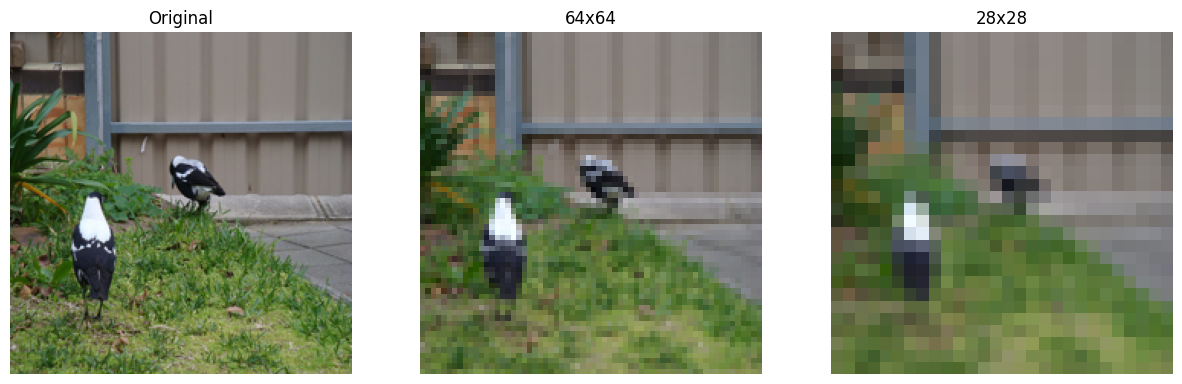

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

img=Image.open("images/SampleImageNet.JPEG").resize((224,224))
imgResized_64=img.resize((64,64))
imgResized_28=img.resize((28,28))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')  
axes[1].imshow(imgResized_64)
axes[1].set_title("64x64")
axes[1].axis('off')  
axes[2].imshow(imgResized_28)
axes[2].set_title("28x28")
axes[2].axis('off')
plt.show()

可以看出，调整尺寸并不是一个好的解决方案，尤其是在需要识别图像细节以进行有效分类或检测时。


### 极其有限的首个隐藏层


当输入大小为 $150528$ 时，如果首个隐藏层包含大量神经元，问题会更加严重。实际上，权重对应于两个连续层之间每个神经元的连接。假设首个隐藏层有 $1024$ 个神经元，那么仅两层之间的连接权重就高达 $150528 \times 1024 = 1.54 \text{ 亿}$，这对于仅两层之间的连接来说是巨大的。

我们可以考虑将首个隐藏层的神经元数量限制在几十个，以减少权重数量。然而，大幅度减少维度会导致信息严重丢失，从而无法通过这种方法获得满意的结果。


### 卷积


**直觉**：图像的一个特点是存在重复的模式。基于这一想法，我们可以考虑在图像的不同像素之间共享权重。

**基本原理**：这引导我们使用卷积层，其通过卷积滤波器遍历图像中的每个像素。这些滤波器的值是可训练的，对应于神经网络的权重。

以下是卷积原理的示意图：

![卷积](./images/conv.png)


**为何有效？**
- 使用卷积层可以避免权重数量随图像尺寸增加，从而能够处理高分辨率的图像。
- 卷积层具有平移不变性，这对于图像非常有用（例如，一张狗的图像向右平移 4 个像素后，仍然是一张狗的图像）。
- 虽然卷积层的信息处理是局部的，但通过多层卷积层的堆叠，可以实现对图像的全局处理（详见下一笔记本中关于感受野的部分）。

**补充信息**：
- 在示意图中，输入图像的尺寸为 $4 \times 4$。实际应用中，彩色图像包含 $3$ 个通道。对于一个 $4 \times 4 \times 3$ 的图像，我们会使用尺寸为 $n \times n \times 3$ 的滤波器，其中 $n$ 是滤波器的大小（示意图中为 $3$）。需要注意的是，卷积滤波器的深度取决于输入层的通道数。
- 卷积可以看作是在全连接层上应用的 *for* 循环，其中一个小滤波器（使用共享权重而非每个连接的唯一权重）在图像上滑动以检测局部模式。这样大大提高了效率，并通过权重共享显著减少了内存需求。


## 卷积层的详细介绍


现在，我们将详细介绍卷积层的各种参数，基于 PyTorch 的 [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) 函数的输入参数。

为了更清晰，卷积层的输出被称为 *特征图（FeatureMap）*。


**in_channels**：输入层的通道数（用于定义所使用的卷积滤波器的深度）。

**out_channels**：卷积层中使用的滤波器数量（也对应于输出 *特征图* 的通道数）。

**kernel_size**：卷积滤波器的尺寸。如果该参数为 $3$，则卷积滤波器的尺寸为 $3 \times 3$。同一层中的所有卷积滤波器必须具有相同的尺寸。

**stride**：*stride* 是卷积滤波器应用时的步长。例如，*stride* 为 $1$ 表示对每个像素应用滤波器，而 *stride* 为 $2$ 表示对每隔一个像素应用滤波器。较大的 *stride* 会减小图像的尺寸（使用 *stride* 为 2 时，输出的 *特征图* 将比 *stride* 为 1 时小一半）。

**padding**：该参数在图像周围添加一个大小为 *padding* 的边框，以便滤波器能够均匀地应用于所有像素，包括边缘像素。如果没有 *padding*，边缘像素将没有邻居，滤波器无法应用，导致卷积后图像尺寸减小。*padding* 通过在应用滤波器前在图像周围添加值（如零或镜像值）来解决这一问题（详见示意图中的 *zero-padding*）。

**padding_mode**：允许选择 *padding* 的模式（例如 "zeros" 表示 *zero-padding*）。

**dilation**：卷积层中的 *dilation* 参数定义了滤波器元素之间的间距，使滤波器能够覆盖更大的区域而不增加其尺寸，从而捕获图像中的更多空间上下文。下图展示了 *dilation* 的效果：

![膨胀（Dilation）](./images/dilation.png)

图片来源：*Du, Jinglong & Wang, Lulu & Liu, Yulu & Zhou, Zexun & He, Zhongshi & Jia, Yuanyuan. (2020). Brain MRI Super-Resolution Using 3D Dilated Convolutional Encoder–Decoder Network. IEEE Access. PP. 1-1. 10.1109/ACCESS.2020.2968395.*


## 池化层


卷积神经网络中的另一个基本层是 *池化层*（Pooling）。该层不包含任何可学习的参数，仅通过对相邻像素进行分组来调整 *特征图* 的尺寸。在接下来的笔记本中，我们将看到该层在卷积神经网络中的应用。池化层还能减少对模式平移和扭曲的敏感性，从而提高泛化能力。


池化主要有两种类型：
**最大池化（MaxPooling）**：*最大池化* 是一种池化方法，通过获取一组相邻像素的最大值，并将其作为缩小后图像的新值。
**平均池化（AveragePooling）**：*平均池化* 获取一组相邻像素的平均值，并将其作为缩小后图像的新值。

下图展示了 *最大池化* 和 *平均池化* 之间的区别：

![池化（Pooling）](./images/pooling.png)
